### Install the Libraries:

The libraries used to run the Summarizer and Metrics.

In [25]:
!pip install bert-extractive-summarizer --quiet
!pip install torchmetrics --quiet


### Importing the Libraries:

In [ ]:
import re
import nltk
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from scipy.sparse.linalg import svds
from torchmetrics.text.rouge import ROUGEScore
from pprint import pprint
nltk.download('all')

### Dataset

A text corpus extracted from the MS^2 dataset to compare BERT vs LSA. This dataset is one of the corpus tested on where LSA outperforms BERT on ROUGE metrics.

In [27]:
body_2 = """I saw ABC back in Neuro-Oncology Clinic today. He comes in for an urgent visit because of increasing questions about what to do next for his anaplastic astrocytoma.
Within the last several days, he has seen you in clinic and once again discussed whether or not to undergo radiation for his left temporal lesion.
The patient has clearly been extremely ambivalent about this therapy for reasons that are not immediately apparent.
It is clear that his MRI is progressing and that it seems unlikely at this time that anything other than radiation would be particularly effective.
Despite repeatedly emphasizing this; however, the patient still is worried about potential long-term side effects from treatment that frankly seem unwarranted at this particular time.
After seeing you in clinic, he and his friend again wanted to discuss possible changes in the chemotherapy regimen.
They came in with a list of eight possible agents that they would like to be administered within the next two weeks.
They then wanted another MRI to be performed and they were hoping that with the use of this type of approach, they might be able to induce another remission from which he can once again be spared radiation.
From my view, I noticed a man whose language has deteriorated in the week since I last saw him. This is very worrisome. Today, for the first time, I felt that there was a definite right facial droop as well.
Therefore, there is no doubt that he is becoming symptomatic from his growing tumor. It suggests that he is approaching the end of his compliance curve and that the things may rapidly deteriorate in the near future.
Emphasizing this once again, in addition, to recommending steroids I once again tried to convince him to undergo radiation. Despite an hour, this again amazingly was not possible.
It is not that he does not want treatment, however. Because I told him that I did not feel it was ethical to just put him on the radical regimen that him and his friend devised,
we compromised and elected to go back to Temodar in a low dose daily type regimen.
We would plan on giving 75 mg/sq m everyday for 21 days out of 28 days. In addition, we will stop thalidomide 100 mg/day.
If he tolerates this for one week, we then agree that we would institute another one of the medications that he listed for us. At this stage, we are thinking of using Accutane at that point.
While I am very uncomfortable with this type of approach, I think as long as he is going to be monitored closely that we may be able to get away with this for at least a reasonable interval.
In the spirit of compromise, he again consented to be evaluated by radiation and this time, seemed more resigned to the fact that it was going to happen sooner than later.
I will look at this as a positive sign because I think radiation is the one therapy from which he can get a reasonable response in the long term.
I will keep you apprised of followups. If you have any questions or if I could be of any further assistance, feel free to contact me.
"""

### Preprocesses a document by removing special characters, converting to lowercase, tokenizing, and filtering out English stopwords from NLTK's corpus.


In [28]:
body_2 = re.sub(r'\n|\r', ' ', body_2)
body_2 = re.sub(r' +', ' ', body_2)
body_2 = body_2.strip()

In [29]:
sentences = nltk.sent_tokenize(body_2)
len(sentences)

27

In [30]:
stop_words = nltk.corpus.stopwords.words('english')

def normalize_body_2(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize body_2
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of body_2
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create body_2 from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc
normalize_corpus = np.vectorize(normalize_body_2)


In [31]:
norm_sentences = normalize_corpus(sentences)
norm_sentences[:3]

array(['saw abc back neurooncology clinic today',
       'comes urgent visit increasing questions next anaplastic astrocytoma',
       'within last several days seen clinic discussed whether undergo radiation left temporal lesion'],
      dtype='<U143')

### Converts normalized sentences into a TF-IDF matrix, transposes it, and displays a sample DataFrame of the transposed matrix with vocabulary.


In [32]:
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
dt_matrix = tv.fit_transform(norm_sentences)
dt_matrix = dt_matrix.toarray()

vocab = tv.get_feature_names_out()
td_matrix = dt_matrix.T
print(td_matrix.shape)
pd.DataFrame(np.round(td_matrix, 2), index=vocab).sample(10)

(192, 27)


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
evaluated,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.00,0.0,0.0,0.00,0.29,0.00,0.0,0.0
lesion,0.0,0.00,0.30,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0
addition,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.46,0.0,0.0,0.00,0.00,0.00,0.0,0.0
anaplastic,0.0,0.36,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0
whose,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.33,...,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0
saw,0.4,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.29,...,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0
long,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.00,0.0,0.0,0.25,0.00,0.28,0.0,0.0
last,0.0,0.00,0.26,0.0,0.0,0.0,0.0,0.0,0.0,0.29,...,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0
convince,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0
rapidly,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0


### Performs Singular Value Decomposition (SVD) on a matrix with a specified number of singular values to compute.


In [33]:
def low_rank_svd(matrix, singular_count=2):
    u, s, vt = svds(matrix, k=singular_count)
    return u, s, vt

### Perform Singular Value Decomposition (SVD) to extract topics from the term-document matrix.

In [34]:
num_sentences = 8
num_topics = 3

u, s, vt = low_rank_svd(td_matrix, singular_count=num_topics)
print(u.shape, s.shape, vt.shape)
term_topic_mat, singular_values, topic_body_2_mat = u, s, vt

(192, 3) (3,) (3, 27)


### Remove singular values below threshold

In [35]:
sv_threshold = 0.5
min_sigma_value = max(singular_values) * sv_threshold
singular_values[singular_values < min_sigma_value] = 0

### Calculate salience scores using the square root of the dot product  of squared singular values and squared topic-body matrix elements.


In [36]:
salience_scores = np.sqrt(np.dot(np.square(singular_values),
                                 np.square(topic_body_2_mat)))

In [37]:
top_sentence_indices = (-salience_scores).argsort()[:num_sentences]
top_sentence_indices.sort()

In [38]:
a=np.array(sentences)[top_sentence_indices]

In [39]:
b = a.tolist()

In [40]:
single_string = ' '.join(b)

# Display the single string
print(single_string)

I saw ABC back in Neuro-Oncology Clinic today. Despite repeatedly emphasizing this; however, the patient still is worried about potential long-term side effects from treatment that frankly seem unwarranted at this particular time. After seeing you in clinic, he and his friend again wanted to discuss possible changes in the chemotherapy regimen. They then wanted another MRI to be performed and they were hoping that with the use of this type of approach, they might be able to induce another remission from which he can once again be spared radiation. It is not that he does not want treatment, however. Because I told him that I did not feel it was ethical to just put him on the radical regimen that him and his friend devised, we compromised and elected to go back to Temodar in a low dose daily type regimen. While I am very uncomfortable with this type of approach, I think as long as he is going to be monitored closely that we may be able to get away with this for at least a reasonable inte

### Result:

We extracted the top 8 sentences and displayed it.

In [41]:
print('\n'.join(np.array(sentences)[top_sentence_indices]))


I saw ABC back in Neuro-Oncology Clinic today.
Despite repeatedly emphasizing this; however, the patient still is worried about potential long-term side effects from treatment that frankly seem unwarranted at this particular time.
After seeing you in clinic, he and his friend again wanted to discuss possible changes in the chemotherapy regimen.
They then wanted another MRI to be performed and they were hoping that with the use of this type of approach, they might be able to induce another remission from which he can once again be spared radiation.
It is not that he does not want treatment, however.
Because I told him that I did not feel it was ethical to just put him on the radical regimen that him and his friend devised, we compromised and elected to go back to Temodar in a low dose daily type regimen.
While I am very uncomfortable with this type of approach, I think as long as he is going to be monitored closely that we may be able to get away with this for at least a reasonable inte

### Metrics:

Torchmetrics library to print the ROUGE scores.|

In [42]:
rouge=ROUGEScore()
pprint(rouge(body_2,single_string))

{'rouge1_fmeasure': tensor(0.5582),
 'rouge1_precision': tensor(0.3872),
 'rouge1_recall': tensor(1.),
 'rouge2_fmeasure': tensor(0.5464),
 'rouge2_precision': tensor(0.3787),
 'rouge2_recall': tensor(0.9810),
 'rougeL_fmeasure': tensor(0.5582),
 'rougeL_precision': tensor(0.3872),
 'rougeL_recall': tensor(1.),
 'rougeLsum_fmeasure': tensor(0.5582),
 'rougeLsum_precision': tensor(0.3872),
 'rougeLsum_recall': tensor(1.)}


### Plot:

A simple plot to show the F1 scores across different ROUGE variants.

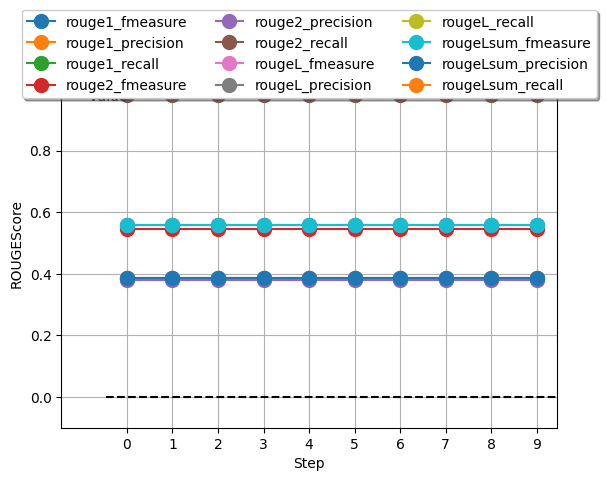

In [43]:
metric = ROUGEScore()
values = [ ]
for _ in range(10):
    values.append(rouge(body_2, single_string))
fig_, ax_ = metric.plot(values)